## Replication guide for "Higher-order Learning" (Evdokimov and Garfagnini, 2021)

-----

## Figure 1

Figure 1 is used in the text as an illustration of the prediction that higher-order beliefs are closer to the prior when information is private. We first derive the players' beliefs in the public treatment (which are identical for all player types), and then derive higher-order beliefs with private information.

### Beliefs in the public treatment

Let $P_1(Orange|n, t)$ denote the probability assigned to the orange state by a Bayesian player, conditional on the number of orange balls $n$ observed in period $t$. This value is computed in the code below using the function `bayes(num_balls,period)`.

We assume in the simulations below that orange is the correct state, so that $P_1(Orange|n, t)$ represents the **normalized first-order belief**. 

The expected value of $P_1(Orange|n, t)$ in every period $t$ can be obtained as:
$$
\sum_{n=1}^t P_1(Orange|n, t) \cdot f(n; Orange, t),
$$
where $f(n; Orange, t)={t \choose n} (2/3)^n \cdot (1/3)^{t-n}$ is the probablity of observing $n$ of orange balls in period $t$, obtained from the Binomial distribution for the orange state. 

### Higher-order beliefs in the private treartment
 
In the private treatment, Player $k$'s expectation of the probability assigned by Player $k-1$ to the state being orange, conditional on the number of orange balls $n$ observed in period $t$, is given by:

\begin{align*}
P_{k}(Orange|n,t)&=P_1(Orange|n,t)\cdot \sum_{n'=1}^t P_{k-1}(Orange|n', t)\cdot f(n'; Orange, t) + \\
&+[1-P_1(Orange|n,t)]\cdot \sum P_{k-1}(Orange|n', t)\cdot f(n'; Purple, t)
\end{align*}

I.e., Player $k$ first forms a posterior belief about the state. For each possible state, she computes the expectation of Player $k-1$'s beliefs over all possible numbers $n'$ of orange balls the Player $k-1$ might observe, using the binomial distribution for that state. This value is computed in the code below using the function `bayes2(num_balls,period)` for Player 2 and `bayes3(num_balls,period)` for Player 3.

The expected value of $P_k(Orange|n, t)$ in every period $t$ can be obtained as:
$$
\sum_{n=1}^t P_k(Orange|n, t) \cdot f(n; Orange, t),
$$
similar to its counterpart for Player 1 in the description above.

-----

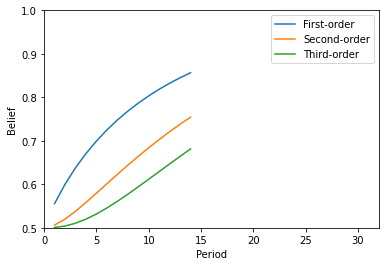

In [1]:
# import packages
from scipy.stats import binom
import matplotlib.pyplot as plt


# set the number of periods 

# change the right end point of the range to generate more predictions 
# (i.e., to 6 for 5 periods, 11 for 10 periods, etc.)
periods = list(range(1,15))


# define bayes' rule
def bayes(num_balls, period):
    return (((2/3) ** num_balls) * ((1/3) ** (period-num_balls))) \
    /(((2 / 3) ** num_balls) * ((1 / 3) ** (period - num_balls))+((1 / 3) ** num_balls) \
      * ((2 / 3) ** (period - num_balls)))


# initialize public beliefs list
beliefs_public = list()


# loop through periods and for each period compute expected first-order belief
for period in periods:
    expected_belief = 0
    for num_balls in range(period+1):
        expected_belief += bayes(num_balls, period) * binom.pmf(num_balls,period,2/3)
    beliefs_public.append(expected_belief)


# define function for private second-order beliefs computed using bayes' rule
def bayes2(num_balls, period):
    # expectation over histories for each state
    sum1 = 0
    sum2 = 0
    for num in range(period+1):
        sum1 += bayes(num, period) * binom.pmf(num, period, 2 / 3)
        sum2 += bayes(num, period) * binom.pmf(num, period, 1 / 3)
    # expectation over states
    return bayes(num_balls, period) * sum1 \
           + (1 - bayes(num_balls, period)) * sum2


# initialize the list of private second-order beliefs
beliefs_private2 = list()


# loop through periods and for each period compute expected private second-order belief
for period in periods:
    expected_belief2 = 0
    for num_balls in range(period+1):
        expected_belief2 += bayes2(num_balls, period) * binom.pmf(num_balls,period,2/3)
    beliefs_private2.append(expected_belief2)


# define function for private third-order beliefs computed using Bayes' rule
def bayes3(num_balls, period):
    # expectation over histories for each state
    sum1 = 0
    sum2 = 0
    for num in range(period+1):
        sum1 += bayes2(num, period) * binom.pmf(num, period, 2 / 3)
        sum2 += bayes2(num, period) * binom.pmf(num, period, 1 / 3)
    # expectation over states
    return bayes(num_balls, period) * sum1 \
           + (1- bayes(num_balls,period)) * sum2


# initialize the list of private second-order beliefs
beliefs_private3 = list()


# loop through periods and for each period compute expected private third-order belief
for period in periods:
    expected_belief3 = 0
    for num_balls in range(period+1):
        expected_belief3 += bayes3(num_balls, period) * binom.pmf(num_balls,period,2/3)
    beliefs_private3.append(expected_belief3)


# MAKE THE PLOT!


plt.plot(periods, beliefs_public)
plt.plot(periods, beliefs_private2)
plt.plot(periods, beliefs_private3)
plt.axis([0, 32, 0.5, 1])
plt.xlabel('Period')
plt.ylabel('Belief')
plt.legend(['First-order', 'Second-order', 'Third-order'],
           loc='best')
plt.show()

## Figure 2 

Figure 2 is used in the text to illustrate the point that the dynamics of the accuracy of higher-order beliefs might depend on the kind of heterogeneity of updating rules present in the data. 

The figure presents the results of three simulations under the assumption of public signals. Each simulation is a function of five parameters: $\lambda_1$, $\lambda_2$, $\lambda_3$, and the number of simulated teams (`num_teams`) and the number of simulated periods for each team (`num_periods`). 

The $\lambda$'s capture the heterogeneity of updating rules in the population from which the simulated teams are drawn. Specifically, following Epstein, et al. (2008), it is assumed that a $\lambda-$player with a prior $\mu_{t}$ about the state of the world and a signal $s$ uses the following updating rule:

\begin{equation}
\mu_{t+1}= \lambda B(\mu_t, s) + (1-\lambda) \mu_t. \qquad (1)
\end{equation}

For each team in `num_teams`, the parameter $\lambda$ are drawn for each player using a uniform distribution over ($\lambda_1$, $\lambda_2$, $\lambda_3$), and the state of the world is drawn using a uniform distribution over $(Orange,\; Purple)$. The players start out with a uniform prior of the state space.

In each period in `num_periods`, a signal is drawn from an orange urn if the state is orange and a purple urn if the state is purple, and the posterior belief of each player is generated following equation (1) above. Belief accuracy is measured as 1 minus the distance between two posterior beliefs. The code below computes belief accuracy for every period and every team and then averages across teams in every period. 

The sequence produced by the `optimal_accuracy` function assumes that in each team, one of the players' $\lambda$ is drawn uniformly from ($\lambda_1$, $\lambda_2$, $\lambda_3$), while the other player's belief in ever period is an average across the beliefs of the $\lambda_1$, $\lambda_2$, and $\lambda_3$ player. I.e., the "optimal" takes the underlyng distribution of $\lambda$'s into account, as opposed to assuming that the other player's $\lambda$ is equal to his own. 

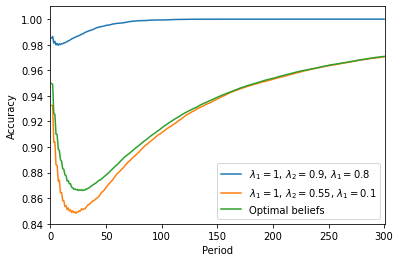

In [2]:
import random
from numpy import mean
import matplotlib.pyplot as plt


# define bayes' rule as function of the signal and the prior
def bayes(orange, prior):
    if orange == 1:
        return ( (2/3) * prior ) / ( (2/3) * prior + (1/3) * (1 - prior))
    if orange == 0:
        return ( (1/3) * prior ) / ( (1/3) * prior + (2/3) * (1 - prior))


# define a function that computes the simulated accuracy path for a given distribution of parameters
def accuracy(par1, par2, par3, num_teams, num_periods):
    acc_dct = dict()

    for team in range(1,num_teams+1):
        # initialize periods at 1
        period = 1
        # initialize priors to 1/2
        prior1 = 1/2
        prior2 = 1/2

        # draw an urn, which can be orange or not
        urn = random.choice([0,1])

        # draw a lambda for player 1 and a lambda from player 2 randomly
        lambda1 = random.choice([par1, par2, par3])
        lambda2 = random.choice([par1, par2, par3])

        # initialize paths of accuracies for the two players
        acc_lst = list()

        while period <= num_periods:
            if urn == 1:
                orange = random.choice([1, 1, 0])
            else:
                orange = random.choice([1, 0, 0])

            belief1 = lambda1 * bayes(orange, prior1) + (1-lambda1) * prior1
            belief2 = lambda2 * bayes(orange, prior2) + (1-lambda2) * prior2
            # append belief accuracy for the given period to the list
            acc_lst.append(1 - abs(belief1-belief2))
            # update period and priors
            period = period + 1
            prior1 = belief1
            prior2 = belief2

        acc_dct[team]=acc_lst

    # create a list of average accuracies in each period
    average_acc = list()
    for index in range(num_periods):
        # to compute average accuracy in period, first put all the teams' accuracies for that period in a list
        period_accs = list()
        # loop over the dictionary and add each team's accuracy for that period to the list above
        for k, v in acc_dct.items():
            period_accs.append(v[index])
        # add the mean across teams to the average accuracies list
        average_acc.append(mean(period_accs))

    # return acc_dct, average_acc
    return average_acc


# the code for generating the path of belief accuracies for a player who optimally takes into account the distribution of types
def optimal_accuracy(par1, par2, par3, num_teams, num_periods):
    acc_opt_dct = dict()

    for team in range(1,num_teams+1):
        # initialize periods at 1
        period = 1
        # initialize priors to 1/2
        prior = 1/2
        prior1 = 1/2
        prior2 = 1/2
        prior3 = 1/2

        # draw an urn, which can be orange or not
        urn = random.choice([0, 1])

        # draw a lambda for the non-optimal player randomly
        lamb = random.choice([par1, par2, par3])

        # initialize paths of accuracies for the two players
        acc_opt_lst = list()

        while period <= num_periods:
            if urn == 1:
                orange = random.choice([1, 1, 0])
            else:
                orange = random.choice([1, 0, 0])

            belief = lamb * bayes(orange, prior) + (1 - lamb) * prior
            belief1 = par1 * bayes(orange, prior1) + (1 - par1) * prior1
            belief2 = par2 * bayes(orange, prior2) + (1 - par2) * prior2
            belief3 = par3 * bayes(orange, prior3) + (1 - par3) * prior3
            belief_opt = (belief1 + belief2 + belief3)/3
            # append belief accuracy for the given period to the list
            acc_opt_lst.append(1 - abs(belief - belief_opt))
            # update period and priors
            period = period + 1
            prior = belief
            prior1 = belief1
            prior2 = belief2
            prior3 = belief3

        acc_opt_dct[team] = acc_opt_lst
    # create a list of average accuracies in each period
    average_acc = list()
    for index in range(num_periods):
        # to compute average accuracy in period, first put all the teams' accuracies for that period in a list
        period_accs = list()
        # loop over the dictionary and add each team's accuracy for that period to the list above
        for k, v in acc_opt_dct.items():
            period_accs.append(v[index])
        # add the mean across teams to the average accuracies list
        average_acc.append(mean(period_accs))

    # return acc_dct, average_acc
    return average_acc


# DRAW THE PATHS!

periods = list(range(1,301))
accuracies1 = accuracy(1, .9, .8, 5000, 300)
accuracies2 = accuracy(1, .55, .1, 5000, 300)
accuracies3 = optimal_accuracy(1, .55, .1, 5000, 300)

# print(accuracies1)
# print(accuracies2)
# print(accuracies3)

plt.plot(periods, accuracies1)
plt.plot(periods, accuracies2)
plt.plot(periods, accuracies3)
plt.axis([0, 301, 0.84, 1.01])
params = {'mathtext.default': 'regular' }
plt.xlabel('Period')
plt.ylabel('Accuracy')
plt.legend(['$\lambda_1=1$, $\lambda_2=0.9$, $\lambda_1=0.8$', '$\lambda_1=1$, $\lambda_2=0.55$, $\lambda_1=0.1$', 'Optimal beliefs'],
           loc='best')
plt.show()


## Figures 3, 5 and 10a

These figures plot the average normalized guesses by treatment and player type (i.e., produce the empirical counterpart to Figure 1). The top row if figures in the resulting output uses data from the lab treatments, the middle row uses data from the MTurk treatments, and the bottom row uses data from the "within-long" treatment. 

The normalized belief is defined as the ``guess_truth`` variable, which is equal to the subject's elicited belief (``guess``) for observations where ``urn``=1 (the urn is orange) and 1-``guess`` for those where the urn is purple. It is then averaged across all subjects, rounds, and observed signal histories. 

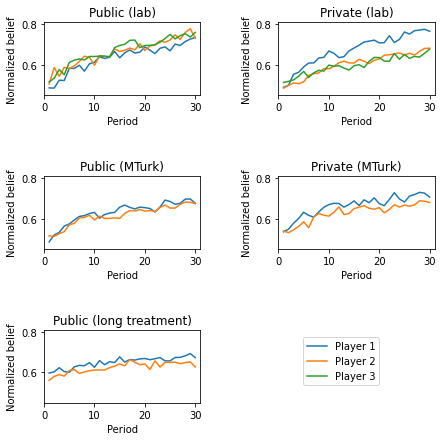

In [3]:
import pandas as pd
from matplotlib import pyplot as plt

# load the data

data = pd.read_csv("data_ee.csv")

# create the normalized beliefs variables

# note that second-order beliefs are saved as guess2 in the mturk treatments, so the averaging there needs to be done separately

data["guess_truth"] = data.apply(lambda row: row["guess"] if row["urn"] == 1 else 1-row["guess"], axis=1)
data["guess2_truth"] = data.apply(lambda row: row["guess2"] if row["urn"] == 1 else 1-row["guess2"], axis=1)

# average the beliefs by treatment, player type, and period

# note that type is meaningless in the mturk treatments, so the averaging there is done separately

data_mean = data.groupby(["mturk", "private", "lon", "gameperiod", "type"]).guess_truth.mean().reset_index()
mturk_mean = data.groupby(["mturk", "private", "lon", "gameperiod"]).guess_truth.mean().reset_index()
mturk2_mean = data.groupby(["mturk", "private", "lon", "gameperiod"]).guess2_truth.mean().reset_index()

# ensure that the data are sorted correctly

data_mean.sort_values(by=["mturk", "lon", "private", "type", "gameperiod"]).reset_index()
mturk_mean.sort_values(by=["mturk", "lon", "private", "gameperiod"]).reset_index()
mturk2_mean.sort_values(by=["mturk", "lon", "private", "gameperiod"]).reset_index()

# make the plots

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))

plt.subplot(3, 2, 1, title="Public (lab)")

plt.plot(range(1,31), data_mean.guess_truth[(data_mean.mturk==0) & (data_mean.lon==0) & (data_mean.private==0) & (data_mean.type==1)])
plt.plot(range(1,31), data_mean.guess_truth[(data_mean.mturk==0) & (data_mean.lon==0) & (data_mean.private==0) & (data_mean.type==2)])
plt.plot(range(1,31), data_mean.guess_truth[(data_mean.mturk==0) & (data_mean.lon==0) & (data_mean.private==0) & (data_mean.type==3)])
plt.xlabel("Period")
plt.ylabel("Normalized belief")
plt.axis([0,31,.45,.81])

plt.subplot(3, 2, 2, title="Private (lab)")

plt.plot(range(1,31), data_mean.guess_truth[(data_mean.mturk==0) & (data_mean.lon==0) & (data_mean.private==1) & (data_mean.type==1)])
plt.plot(range(1,31), data_mean.guess_truth[(data_mean.mturk==0) & (data_mean.lon==0) & (data_mean.private==1) & (data_mean.type==2)])
plt.plot(range(1,31), data_mean.guess_truth[(data_mean.mturk==0) & (data_mean.lon==0) & (data_mean.private==1) & (data_mean.type==3)])
plt.xlabel("Period")
plt.ylabel("Normalized belief")
plt.axis([0,31,.45,.81])

plt.subplot(3, 2, 3, title="Public (MTurk)")

plt.plot(range(1,31), mturk_mean.guess_truth[(mturk_mean.mturk==1) & (mturk_mean.lon==0) & (mturk_mean.private==0)])
plt.plot(range(1,31), mturk2_mean.guess2_truth[(mturk2_mean.mturk==1) & (mturk2_mean.lon==0) & (mturk2_mean.private==0)])
plt.xlabel("Period")
plt.ylabel("Normalized belief")
plt.axis([0,31,.45,.81])

plt.subplot(3, 2, 4, title="Private (MTurk)")

plt.plot(range(1,31), mturk_mean.guess_truth[(mturk_mean.mturk==1) & (mturk_mean.lon==0) & (mturk_mean.private==1)])
plt.plot(range(1,31), mturk2_mean.guess2_truth[(mturk2_mean.mturk==1) & (mturk2_mean.lon==0) & (mturk2_mean.private==1)])
plt.xlabel("Period")
plt.ylabel("Normalized belief")
plt.axis([0,31,.45,.81])

plt.subplot(3, 2, 5, title="Public (long treatment)")

plt.plot(range(1,31), mturk_mean.guess_truth[(mturk_mean.mturk==1) & (mturk_mean.lon==1) & (mturk_mean.private==0)])
plt.plot(range(1,31), mturk2_mean.guess2_truth[(mturk2_mean.mturk==1) & (mturk2_mean.lon==1) & (mturk2_mean.private==0)])
plt.xlabel("Period")
plt.ylabel("Normalized belief")
plt.axis([0,31,.45,.81])

plt.subplots_adjust(wspace=.5)
plt.subplots_adjust(hspace=1.1)

fig.legend(["Player 1", "Player 2", "Player 3"], loc='lower right', bbox_to_anchor=(0.8, .15)
)

plt.show()

## Table 1

This table produces the results of several regressions testing for the effect of private information on higher-order beliefs in the lab treatments. The dependent variable is the normalized belief (``guess_truth``). The first two columns focus on Players 2 and 3 in both the private treatment; the next two focus on Players 1-3 in the private treatment; and the last two focus on Players 1-3 in the public treatment. Only laboratory data are used. 

That the ``private`` variable is significant and negative in the first two columns and the ``dum2`` and ``dum3`` dummies are significant in the second two columns suggests that higher-order beliefs are biased toward the prior when information is private, consistent with the theoretical predictions.

In [4]:
import statsmodels.formula.api as sm
import pandas as pd
from stargazer.stargazer import Stargazer

# load data

df = pd.read_csv("data_ee.csv")

# define the needed variables

df["guess_truth"]=df.apply(lambda row: row["guess"] if row.urn==1 else 1-row["guess"], axis=1)
df["dum2"]=df.apply(lambda row: 1 if row["type"] == 2 else 0, axis=1)
df["dum3"]=df.apply(lambda row: 1 if row["type"] == 3 else 0, axis=1)

# estimate the regression models

reg1 = sm.ols(formula='guess_truth ~ private', data=df[(df.mturk == 0) & (df.type>1)]).fit(cov_type='cluster', cov_kwds={'groups': df[(df.mturk==0) & (df.type>1)]["unique"]}, use_t=True)
reg2 = sm.ols(formula='guess_truth ~ private * gameperiod', data=df[(df.mturk == 0) & (df.type>1)]).fit(cov_type='cluster', cov_kwds={'groups': df[(df.mturk==0) & (df.type>1)]['unique']}, use_t=True)
reg3 = sm.ols(formula='guess_truth ~ dum2 + dum3', data=df[(df.private==1) & (df.mturk==0)]).fit(cov_type="cluster", cov_kwds={'groups': df[(df.mturk==0) & (df.private==1)]["unique"]}, use_t=True)
reg4 = sm.ols(formula='guess_truth ~ gameperiod * dum2 + gameperiod * dum3', data=df[(df.mturk == 0) & (df.private==1)]).fit(cov_type="cluster", cov_kwds={"groups": df[(df.mturk==0) & (df.private==1)]["unique"]}, use_t=True)
reg5 = sm.ols(formula='guess_truth ~ dum2 + dum3', data=df[(df.private==0) & (df.mturk==0)]).fit(cov_type="cluster", cov_kwds={'groups': df[(df.mturk==0) & (df.private==0)]["unique"]}, use_t=True)
reg6 = sm.ols(formula='guess_truth ~ gameperiod * dum2 + gameperiod * dum3', data=df[(df.mturk == 0) & (df.private==0)]).fit(cov_type="cluster", cov_kwds={"groups": df[(df.mturk==0) & (df.private==0)]["unique"]}, use_t=True)

# uncomment the code below to make the table in the following cell 

# Stargazer([reg1, reg2, reg3, reg4, reg5, reg6]).render_html()

<table style="text-align:center"><tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="6"><em>Dependent variable:guess_truth</em></td></tr><tr><td style="text-align:left"></td><tr><td style="text-align:left"></td><td>(1)</td><td>(2)</td><td>(3)</td><td>(4)</td><td>(5)</td><td>(6)</td></tr><tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Intercept</td><td>0.666<sup>***</sup></td><td>0.557<sup>***</sup></td><td>0.673<sup>***</sup></td><td>0.541<sup>***</sup></td><td>0.636<sup>***</sup></td><td>0.526<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(0.016)</td><td>(0.014)</td><td>(0.028)</td><td>(0.021)</td><td>(0.029)</td><td>(0.022)</td></tr><tr><td style="text-align:left">dum2</td><td></td><td></td><td>-0.070<sup>*</sup></td><td>-0.033<sup></sup></td><td>0.026<sup></sup></td><td>0.028<sup></sup></td></tr><tr><td style="text-align:left"></td><td></td><td></td><td>(0.036)</td><td>(0.026)</td><td>(0.037)</td><td>(0.028)</td></tr><tr><td style="text-align:left">dum3</td><td></td><td></td><td>-0.074<sup>**</sup></td><td>-0.015<sup></sup></td><td>0.034<sup></sup></td><td>0.034<sup></sup></td></tr><tr><td style="text-align:left"></td><td></td><td></td><td>(0.034)</td><td>(0.025)</td><td>(0.037)</td><td>(0.029)</td></tr><tr><td style="text-align:left">gameperiod</td><td></td><td>0.007<sup>***</sup></td><td></td><td>0.009<sup>***</sup></td><td></td><td>0.007<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td></td><td>(0.001)</td><td></td><td>(0.001)</td><td></td><td>(0.001)</td></tr><tr><td style="text-align:left">gameperiod:dum2</td><td></td><td></td><td></td><td>-0.002<sup></sup></td><td></td><td>-0.000<sup></sup></td></tr><tr><td style="text-align:left"></td><td></td><td></td><td></td><td>(0.002)</td><td></td><td>(0.002)</td></tr><tr><td style="text-align:left">gameperiod:dum3</td><td></td><td></td><td></td><td>-0.004<sup>**</sup></td><td></td><td>-0.000<sup></sup></td></tr><tr><td style="text-align:left"></td><td></td><td></td><td></td><td>(0.002)</td><td></td><td>(0.001)</td></tr><tr><td style="text-align:left">private</td><td>-0.065<sup>***</sup></td><td>-0.040<sup>**</sup></td><td></td><td></td><td></td><td></td></tr><tr><td style="text-align:left"></td><td>(0.022)</td><td>(0.017)</td><td></td><td></td><td></td><td></td></tr><tr><td style="text-align:left">private:gameperiod</td><td></td><td>-0.002<sup></sup></td><td></td><td></td><td></td><td></td></tr><tr><td style="text-align:left"></td><td></td><td>(0.001)</td><td></td><td></td><td></td><td></td></tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align: left">Observations</td><td>14,940</td><td>14,940</td><td>11,610</td><td>11,610</td><td>10,800</td><td>10,800</td></tr><tr><td style="text-align: left">R<sup>2</sup></td><td>0.015</td><td>0.056</td><td>0.016</td><td>0.063</td><td>0.002</td><td>0.046</td></tr><tr><td style="text-align: left">Adjusted R<sup>2</sup></td><td>0.015</td><td>0.056</td><td>0.016</td><td>0.062</td><td>0.002</td><td>0.046</td></tr><tr><td style="text-align: left">Residual Std. Error</td><td>0.265 (df=14938)</td><td>0.259 (df=14936)</td><td>0.266 (df=11607)</td><td>0.259 (df=11604)</td><td>0.293 (df=10797)</td><td>0.286 (df=10794)</td></tr><tr><td style="text-align: left">F Statistic</td><td>8.644<sup>***</sup> (df=1; 14938)</td><td>49.586<sup>***</sup> (df=3; 14936)</td><td>2.636<sup>*</sup> (df=2; 11607)</td><td>21.024<sup>***</sup> (df=5; 11604)</td><td>0.447<sup></sup> (df=2; 10797)</td><td>30.344<sup>***</sup> (df=5; 10794)</td></tr><tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align: left">Note:</td>
 <td colspan="6" style="text-align: right">
  <sup>*</sup>p&lt;0.1;
  <sup>**</sup>p&lt;0.05;
  <sup>***</sup>p&lt;0.01
 </td></tr></table>

## Figures 4, 6, and 10b 

These figures illustrate how the accuracy of higher-order beliefs evolves as more public or private information about the state of the world is received. 

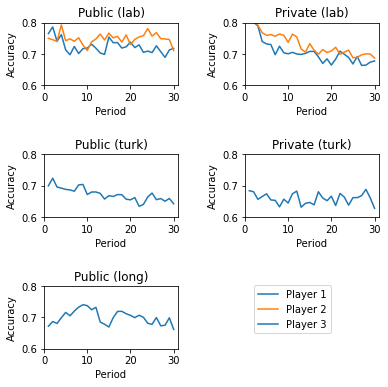

In [5]:
import pandas as pd
from matplotlib import pyplot as plt

# load the data
df = pd.read_csv("data_ee.csv")

# sort the data and create a variable keeping track of the partner's guess (row above or below, depending on condition)
df = df.sort_values(by=["lon", "mturk", "private", "ses", "round", "gameperiod", "group", "type"]).reset_index()
df["guess_prev"] = df.shift(1).guess
df["guess_next"] = df.shift(-1).guess


# define a function for computing belief accuracy
def acc_compute(row):
    if row.mturk == 0:
        return 1-abs(row["guess"]-row["guess_prev"])
    elif (row.mturk == 1) & (row.type == 2):
        return 1 - abs(row["guess2"] - row["guess_prev"])
    elif (row.mturk == 1) & (row.type == 1):
        return 1 - abs(row["guess2"]-row["guess_next"])


# apply this function to every row
df["acc"] = df.apply(acc_compute, axis=1)


# create a variable indexing player role in both lab and mturk treatments
def labtype(row):
    if row["mturk"]==0:
        return row["type"]
    else:
        return 2

df["labtype"] = df.apply(labtype, axis=1)


# compute mean accuracy by player role
acc_mean = df[df.labtype>1].groupby(["mturk", "lon", "private", "gameperiod", "labtype"]).acc.mean().reset_index()


# make the plots
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 6))

plt.subplot(3, 2, 1, title="Public (lab)")

plt.plot(range(1,31), acc_mean[(acc_mean.mturk==0) & (acc_mean.lon==0) & (acc_mean.private==0) & (acc_mean.labtype==2)].acc)
plt.plot(range(1,31), acc_mean[(acc_mean.mturk==0) & (acc_mean.lon==0) & (acc_mean.private==0) & (acc_mean.labtype==3)].acc)
plt.axis([0,31,.6,.8])
plt.xlabel("Period")
plt.ylabel("Accuracy")

plt.subplot(3, 2, 2, title="Private (lab)")

plt.plot(range(1,31), acc_mean[(acc_mean.mturk==0) & (acc_mean.lon==0) & (acc_mean.private==1) & (acc_mean.labtype==2)].acc)
plt.plot(range(1,31), acc_mean[(acc_mean.mturk==0) & (acc_mean.lon==0) & (acc_mean.private==1) & (acc_mean.labtype==3)].acc)
plt.axis([0,31,.6,.8])
plt.xlabel("Period")
plt.ylabel("Accuracy")

plt.subplot(3, 2, 3, title="Public (turk)")

plt.plot(range(1,31), acc_mean[(acc_mean.mturk==1) & (acc_mean.lon==0) & (acc_mean.private==0) & (acc_mean.labtype==2)].acc)
plt.axis([0,31,.6,.8])
plt.xlabel("Period")
plt.ylabel("Accuracy")

plt.subplot(3, 2, 4, title="Private (turk)")

plt.plot(range(1,31), acc_mean[(acc_mean.mturk==1) & (acc_mean.lon==0) & (acc_mean.private==1) & (acc_mean.labtype==2)].acc)
plt.axis([0,31,.6,.8])
plt.xlabel("Period")
plt.ylabel("Accuracy")

plt.subplot(3, 2, 5, title="Public (long)")

plt.plot(range(1,31), acc_mean[(acc_mean.mturk==1) & (acc_mean.lon==1) & (acc_mean.private==0) & (acc_mean.labtype==2)].acc)
plt.axis([0,31,.6,.8])
plt.xlabel("Period")
plt.ylabel("Accuracy")

plt.subplots_adjust(wspace=.5)
plt.subplots_adjust(hspace=1.1)

fig.legend(["Player 1", "Player 2", "Player 3"], loc='lower right', bbox_to_anchor=(0.8, .15)
)

plt.show()

## Table 2

This table analyzes the effects of private information and experience with the game on belief accuracy, defined as 1 minus the distance between the belief of Player $k$ and that of Player $k-1$, for $k>1$. The first four columns use data from the public and the last two from the private treatment. 

Contrary to the Bayesian predictions, the effect of the ``private`` variable is never significantly positive. Moreover, the effect of the ``gameperiod`` variable is never significantly positive, suggesting a failure of higher-order learning.

In [6]:
import pandas as pd
import statsmodels.formula.api as sm
from stargazer.stargazer import Stargazer

df = pd.read_csv('data_ee.csv')

# sort the data and create a variable keeping track of the partner's guess (row above or below, depending on condition)

df = df.sort_values(by=["lon", "mturk", "private", "ses", "round", "gameperiod", "group", "type"]).reset_index()
df["guess_prev"] = df.shift(1).guess
df["guess_next"] = df.shift(-1).guess

# define a function for computing belief accuracy

def acc_compute(row):
    if row.mturk == 0:
        return 1-abs(row["guess"]-row["guess_prev"])
    elif (row.mturk == 1) & (row.type == 2):
        return 1 - abs(row["guess2"] - row["guess_prev"])
    elif (row.mturk == 1) & (row.type == 1):
        return 1 - abs(row["guess2"]-row["guess_next"])


# apply this function to every row
df["acc"] = df.apply(acc_compute, axis=1)

# run the regressions
reg1 = sm.ols(formula="acc ~ private", data=df[(df.mturk==0) & (df.type>1)]).fit(cov_type="cluster", cov_kwds={"groups": df[(df.mturk==0) & (df.type>1)]["unique"]}, use_t=True)
reg2 = sm.ols(formula="acc ~ private", data=df[(df.mturk == 0) & (df.type == 2)]).fit(cov_type="cluster", cov_kwds={"groups": df[(df.mturk == 0) & (df.type == 2)]["unique"]}, use_t=True)
reg3 = sm.ols(formula="acc ~ private", data=df[(df.mturk==0) & (df.type==3)]).fit(cov_type="cluster", cov_kwds={"groups": df[(df.mturk==0) & (df.type==3)]["unique"]}, use_t=True)
reg4 = sm.ols(formula="acc ~ private * gameperiod", data=df[(df.mturk==0) & (df.type>1)]).fit(cov_type="cluster", cov_kwds={"groups": df[(df.mturk==0) & (df.type>1)]["unique"]}, use_t=True)
reg5 = sm.ols(formula="acc ~ private", data=df[(df.mturk==1) & (df.lon==0)]).fit(cov_type="cluster", cov_kwds={"groups": df[(df.mturk==1) & (df.lon==0)]["unique"]}, use_t=True)
reg6 = sm.ols(formula="acc ~ private * gameperiod", data=df[(df.mturk==1) & (df.lon==0)]).fit(cov_type="cluster", cov_kwds={"groups": df[(df.mturk==1) & (df.lon==0)]["unique"]}, use_t=True)

# uncomment the code below to make the table in the following cell 

# print(Stargazer([reg1, reg2, reg3, reg4, reg5, reg6]).render_html())

<table style="text-align:center"><tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="6"><em>Dependent variable:acc</em></td></tr><tr><td style="text-align:left"></td><tr><td style="text-align:left"></td><td>(1)</td><td>(2)</td><td>(3)</td><td>(4)</td><td>(5)</td><td>(6)</td></tr><tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Intercept</td><td>0.736<sup>***</sup></td><td>0.724<sup>***</sup></td><td>0.749<sup>***</sup></td><td>0.745<sup>***</sup></td><td>0.672<sup>***</sup></td><td>0.703<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(0.015)</td><td>(0.022)</td><td>(0.020)</td><td>(0.014)</td><td>(0.012)</td><td>(0.013)</td></tr><tr><td style="text-align:left">gameperiod</td><td></td><td></td><td></td><td>-0.001<sup></sup></td><td></td><td>-0.002<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td></td><td></td><td></td><td>(0.001)</td><td></td><td>(0.001)</td></tr><tr><td style="text-align:left">private</td><td>-0.017<sup></sup></td><td>-0.017<sup></sup></td><td>-0.018<sup></sup></td><td>0.031<sup></sup></td><td>-0.014<sup></sup></td><td>-0.040<sup>**</sup></td></tr><tr><td style="text-align:left"></td><td>(0.019)</td><td>(0.028)</td><td>(0.025)</td><td>(0.019)</td><td>(0.017)</td><td>(0.019)</td></tr><tr><td style="text-align:left">private:gameperiod</td><td></td><td></td><td></td><td>-0.003<sup>***</sup></td><td></td><td>0.002<sup>*</sup></td></tr><tr><td style="text-align:left"></td><td></td><td></td><td></td><td>(0.001)</td><td></td><td>(0.001)</td></tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align: left">Observations</td><td>14,940</td><td>7,470</td><td>7,470</td><td>14,940</td><td>10,620</td><td>10,620</td></tr><tr><td style="text-align: left">R<sup>2</sup></td><td>0.001</td><td>0.001</td><td>0.002</td><td>0.011</td><td>0.001</td><td>0.003</td></tr><tr><td style="text-align: left">Adjusted R<sup>2</sup></td><td>0.001</td><td>0.001</td><td>0.001</td><td>0.010</td><td>0.001</td><td>0.003</td></tr><tr><td style="text-align: left">Residual Std. Error</td><td>0.238 (df=14938)</td><td>0.249 (df=7468)</td><td>0.225 (df=7468)</td><td>0.236 (df=14936)</td><td>0.262 (df=10618)</td><td>0.262 (df=10616)</td></tr><tr><td style="text-align: left">F Statistic</td><td>0.825<sup></sup> (df=1; 14938)</td><td>0.360<sup></sup> (df=1; 7468)</td><td>0.482<sup></sup> (df=1; 7468)</td><td>7.274<sup>***</sup> (df=3; 14936)</td><td>0.623<sup></sup> (df=1; 10618)</td><td>3.437<sup>**</sup> (df=3; 10616)</td></tr><tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align: left">Note:</td>
 <td colspan="6" style="text-align: right">
  <sup>*</sup>p&lt;0.1;
  <sup>**</sup>p&lt;0.05;
  <sup>***</sup>p&lt;0.01
 </td></tr></table>

## Figure 7

This figure is used to document the heterogeneity in subjects' updating rules. Let $\mu_t$ denote the reported belief in period $t$. The following model is estimated for each subject:

$$ \log \frac{\mu_{t-1}}{1-\mu_{t-1}} = \beta_{prior} \log \frac{\mu_{t-1}}{1-\mu_{t-1}} + \beta_{LR} log( LR_{t}) + \beta + \epsilon_t $$, 

where $log(LR_{t})=log(2)$ if an orange signal is observed in period $t$ and $log(1/2)$ otherwise. The analysis focuses on the laboratory treatment with public signals. The code generates histograms for the estimated coefficients $\beta_{prior}$ and $\beta_{LR}$, plotted separately for each Player $k \in \{ 1, 2, 3\}$. 

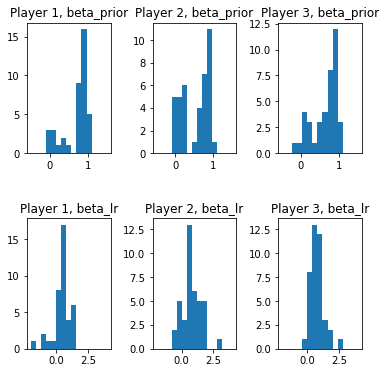

In [7]:
import pandas as pd
import numpy
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt

# load data
df = pd.read_csv("data_ee.csv")

# focus on public lab treatment
df = df[(df.mturk == 0) & (df.private == 0)]

# sort chronologically
df = df.sort_values(by=["unique", "round", "gameperiod"])

# create variables
df["prior"] = df["guess"].shift(1)
df["x2"] = df.apply(lambda row: numpy.log(2) if row["orange"] == 1 else numpy.log(0.5), axis=1)


# replace 0's and 1's
def replace(value):
    if value == 0:
        return 0.01
    elif value == 1:
        return 0.99
    else:
        return value


df["guess_tr"] = df.apply(lambda row: replace(row["guess"]), axis=1)
df["prior_tr"] = df.apply(lambda row: replace(row["prior"]), axis=1)
df["y"] = numpy.log(df["guess_tr"]/(1-df["guess_tr"]))
df["x1"] = numpy.log(df["prior_tr"]/(1-df["prior_tr"]))
df["unique"] = pd.to_numeric(df["unique"])

# set the period 1 prior to 1/2
df.loc[(df.gameperiod == 1), 'x1'] = 0

# create a list of subjects in each role
sub_list = df.groupby(["type", "unique"]).count().reset_index()

# initialize dictionaries
betas_prior = dict()
betas_lr = dict()

for type in [1, 2, 3]:
    # the dictionary key is the player type, the value is a list of estimated parameters
    betas_prior[type]=list()
    betas_lr[type]=list()
    # run a loop to populate the list
    for sub in list(sub_list.unique[(sub_list.type==type)]):
        reg = sm.ols(formula="y ~ x1 + x2", data=df[df["unique"]==sub]).fit()
        betas_prior[type].append(reg.params[1])
        betas_lr[type].append(reg.params[2])

# make the plots

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(6, 6))

plt.subplot(2,3,1, title="Player 1, beta_prior")
plt.hist(betas_prior[1], range=(-.5,1.5), bins=15)

plt.subplot(2,3,2, title="Player 2, beta_prior")
plt.hist(betas_prior[2], range=(-.5,1.5), bins=15)

plt.subplot(2,3,3, title="Player 3, beta_prior")
plt.hist(betas_prior[3], range=(-.5,1.5), bins=15)

plt.subplot(2,3,4, title="Player 1, beta_lr")
plt.hist(betas_lr[1], range=(-2,4), bins=15)

plt.subplot(2,3,5, title="Player 2, beta_lr")
plt.hist(betas_lr[2], range=(-2,4), bins=15)

plt.subplot(2,3,6, title="Player 3, beta_lr")
plt.hist(betas_lr[3], range=(-2,4), bins=15)

plt.subplots_adjust(wspace=.5)
plt.subplots_adjust(hspace=.5)

plt.show()

## Figure 8

This figure uses the coefficient estimates above to simulate paths of long-run beliefs for players in the laboratory public treatment. The first part of the code generates the coefficients above using the Grether (1980) model:

$$ \log \frac{\mu_{t-1}}{1-\mu_{t-1}} = \beta_{prior} \log \frac{\mu_{t-1}}{1-\mu_{t-1}} + \beta_{LR} log( LR_{t}) + \beta + \epsilon_t $$

The latter part generates simulated paths of belief accuracies as follows. First, parameters ``numgroups`` and ``numperiods`` are chosen to determine the number of groups in the simulation and the number of periods for each group. 

Then, a ``for`` loop is used to generated paths of belief accuracies for each group. At the beginning of the loop, the state (orange or purple) is drawn for the group of three players, as well as the updating parameters ($\beta_{prior}$, $\beta_{LR}$, and $\beta$). For each player type 1-3, the parameters are drawn from the empirical distribution for that player type. The prior beliefs are initialized to 0.5.

In each period, a signal is drawn in each period, and the beliefs of each player are determined by the ``posterior`` function: 

$$ E[\mu_{n} | \mu_{n - 1}, LR] %= \frac{\left(\frac{\mu_{n-1}}{1 - \mu_{n-1}}\right) ^{\beta_{1}} LR _{C}^{\beta_{2}}}{1 + \left(\frac{\mu_{n-1}}{1 - \mu_{n-1}}\right) ^{\beta_{1}} LR _{C}^{\beta_{2}}} 
%= \frac{1}{1 + \left(\frac{1 - \mu_{n-1}}{\mu_{n-1}}\right) ^{\beta_{Prior}} \frac{1}{LR _{C}^{\beta_{LR}}}} 
= \frac{\mu_{n-1}^{\beta_{Prior}}}{ \mu_{n-1}^{\beta_{Prior}} + e ^{-\beta_{0}} (1 - \mu_{n -1})^{\beta_{Prior}} LR^{-\beta_{LR}} } $$

Belief accuracies for Players 2 and 3 are then defined on the basis of these posterior beliefs. 

In addition to computing the beliefs of the randomly drawn players, the code computes the beliefs of each possible player type in the role of Player $k$ for $k<3$ and averages across types. This defines the optimal belief of Player $k+1$, i.e. the belief of the player who correctly takes the distribution of types into account. The simulated paths of belief accuracies are saved in a dictionay, in which each key is a group and the value the simulated paths for that group.

The code then uses this dictionary to compute per-period average belief accuracies across groups. 

**Note:** the simulation below sets the number of groups to 50, as the code is computationally intensive. 5000 groups are used for the figure in the text. 


0.7446015878230525
0.7874844323345849


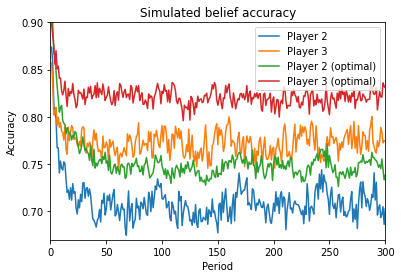

In [8]:
import pandas as pd
import numpy
import statsmodels.formula.api as sm
import random
import matplotlib.pyplot as plt

# load data
df = pd.read_csv("data_ee.csv")

# focus on public lab treatment
df = df[(df.mturk == 0) & (df.private == 0)]

# sort chronologically
df = df.sort_values(by=["unique", "round", "gameperiod"])

# create prior and LR variables for the Grether regressions
df["prior"] = df["guess"].shift(1)
df["x2"] = df.apply(lambda row: numpy.log(2) if row["orange"] == 1 else numpy.log(0.5), axis=1)


# replace 0's and 1's to make all logs well-defined
def replace(value):
    if value == 0:
        return 0.01
    elif value == 1:
        return 0.99
    else:
        return value

# transform prior and posterior using the function above
df["guess_tr"] = df.apply(lambda row: replace(row["guess"]), axis=1)
df["prior_tr"] = df.apply(lambda row: replace(row["prior"]), axis=1)
df["y"] = numpy.log(df["guess_tr"]/(1-df["guess_tr"]))
df["x1"] = numpy.log(df["prior_tr"]/(1-df["prior_tr"]))
df["unique"] = pd.to_numeric(df["unique"])

# set the period 1 prior to 1/2
df.loc[(df.gameperiod == 1), 'x1'] = 0

# create a list of subjects in each role
sub_list = df.groupby(["type", "unique"]).count().reset_index()

# initialize dictionaries for saving regression output
inter = dict()
betas_prior = dict()
betas_lr = dict()

for type in [1, 2, 3]:
    # the dictionary key is the player type, the value is a list of estimated parameters
    inter[type]=list()
    betas_prior[type]=list()
    betas_lr[type]=list()
    # run a loop to populate the list
    for sub in list(sub_list.unique[(sub_list.type==type)]):
        reg = sm.ols(formula="y ~ x1 + x2", data=df[df["unique"]==sub]).fit()
        inter[type].append(reg.params[0])
        betas_prior[type].append(reg.params[1])
        betas_lr[type].append(reg.params[2])

df1 = pd.DataFrame(list(zip(inter[1], betas_prior[1], betas_lr[1])), columns=['inter', 'betas_prior', 'betas_lr'])
df2 = pd.DataFrame(list(zip(inter[2], betas_prior[2], betas_lr[2])), columns=['inter', 'betas_prior', 'betas_lr'])

# simulate the paths of belief accuracies

# define numbers of groups and periods in the simulation
numgroups = 100
numperiods = 300

# initialize dictionary for saving the results for every group (key is group label)
group_dict = dict()


# define the Grether-style updating function
def posterior(prior, lr, bp, bl, inter):
    return (prior ** bp) / ((prior ** bp) + ((numpy.exp(-inter)) * ((1-prior) ** bp) * (lr ** (-bl))))


# create a dictionary, where the keys are groups and the values are simulated paths of belief accuracies
for group in range(1,numgroups+1):
    # initialize the path
    group_path = list()
    period = 1

    # initialize beliefs
    belief1 = 0.5
    belief2 = 0.5
    belief3 = 0.5
    df1["guess"] = 0.5
    df2["guess"] = 0.5

    # draw the urn
    urn = random.choice([1, 2])

    # draw the updating parameters for the regular players
    inter1, bp1, bl1 = random.choice(list(zip(inter[1], betas_prior[1], betas_lr[1])))
    inter2, bp2, bl2 = random.choice(list(zip(inter[2], betas_prior[2], betas_lr[2])))
    inter3, bp3, bl3 = random.choice(list(zip(inter[3], betas_prior[3], betas_lr[3])))

    # then simulate an experiment for the group
    while period <= numperiods:

        # draw a signal in every period
        if urn == 1:
            signal = random.choice([1, 1, 0])
        else:
            signal = random.choice([1, 0, 0])
        if signal == 1:
            lr = 2
        else:
            lr = 1/2

        # compute regular players' beliefs
        belief1 = posterior(belief1, lr, bp1, bl1, inter1)
        belief2 = posterior(belief2, lr, bp2, bl2, inter2)
        belief3 = posterior(belief3, lr, bp3, bl3, inter3)

        # compute optimal players' beliefs
        df1["guess"] = posterior(df1["guess"], lr, df1["betas_prior"], df1["betas_lr"], df1["inter"])
        df2["guess"] = posterior(df2["guess"], lr, df2["betas_prior"], df2["betas_lr"], df2["inter"])
        belief_opt2 = numpy.mean(df1["guess"])
        belief_opt3 = numpy.mean(df2["guess"])

        # compute belief accuracies
        acc2 = 1-abs(belief2-belief1)
        acc3 = 1-abs(belief3-belief2)
        acc2_opt = 1-abs(belief_opt2-belief1)
        acc3_opt = 1-abs(belief_opt3-belief2)

        # save the accuracies for the period
        group_path.append([acc2, acc3, acc2_opt, acc3_opt])
        period = period+1

    # save the whole path of accuracies for the group as a dictionary value
    group_dict[group] = group_path


# to create the per-period averages, first initialize the lists
acc2_mean=list()
acc3_mean=list()
acc2opt_mean=list()
acc3opt_mean=list()

# then compute the average for every period across groups, saving the result as a value in the list
for period in range(1, numperiods+1):
    acc2_list=list()
    acc3_list=list()
    acc2opt_list=list()
    acc3opt_list=list()

    for group in range(1, numgroups+1):
        acc2_list.append(group_dict[group][period-1][0])
        acc3_list.append(group_dict[group][period-1][1])
        acc2opt_list.append(group_dict[group][period - 1][2])
        acc3opt_list.append(group_dict[group][period - 1][3])

    acc2_mean.append(numpy.mean(acc2_list))
    acc3_mean.append(numpy.mean(acc3_list))
    acc2opt_mean.append(numpy.mean(acc2opt_list))
    acc3opt_mean.append(numpy.mean(acc3opt_list))

print(numpy.mean(acc2_mean[0:31]))
print(numpy.mean(acc3_mean[0:31]))

# plot the results

plt.plot(range(1,numperiods+1), acc2_mean)
plt.plot(range(1,numperiods+1), acc3_mean)
plt.plot(range(1,numperiods+1), acc2opt_mean)
plt.plot(range(1,numperiods+1), acc3opt_mean)
plt.legend(["Player 2", "Player 3", "Player 2 (optimal)", "Player 3 (optimal)"])
plt.axis([0,300,.67,.9])
plt.title("Simulated belief accuracy")
plt.xlabel("Period")
plt.ylabel("Accuracy")

plt.show()